In [2]:
import pandas as pd
import numpy as np
np.random.seed(0)
from scipy.stats import beta as sp_beta
from scipy.optimize import linear_sum_assignment

import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.insert(0, '..')
import assignment
import leximin_assignment
import matrix_gen

In [3]:
def custom_eff_assignment(cost_matrix, capacities):
    full_cost_matrix = np.repeat(cost_matrix, capacities, axis=1)
    row_ind, col_ind = linear_sum_assignment(full_cost_matrix)
    
    return (
        col_ind // (cost_matrix.shape[0] // cost_matrix.shape[1]),
        full_cost_matrix[row_ind, col_ind].sum()
    )


N = 30
N_INTVS = 5
N_EXPERIMENTS = 1000
CAPACITIES = np.ones((N_INTVS,), dtype=int) * (N // N_INTVS)

ALPHAS = [0.1, 0.2, 0.4, 0.6, 0.8, 1, 2, 4, 6, 8]
BETAS = [0.1, 0.2, 0.4, 0.6, 0.8, 1, 2, 4, 6, 8]

In [4]:
rerun = False

if rerun:
    lu_cost_pop = [[[] for __ in BETAS] for _ in ALPHAS]
    ln_cost_pop = [[[] for __ in BETAS] for _ in ALPHAS]
    eff_cost_pop = [[[] for __ in BETAS] for _ in ALPHAS]

    for a_id, a in enumerate(ALPHAS):
        for b_id, b in enumerate(BETAS):
            matrix_generator = matrix_gen.MatrixGenerator(
                np.random.beta, (a, b), N, N_INTVS
            )

            success_count = 0
            while success_count < N_EXPERIMENTS:
                (_, sorted_matrix), (__, sorted_increase_matrix) = matrix_generator.get_increase_matrix_pair(
                    round_=False
                )

                # Norm leximin
                lex_n_assigner = leximin_assignment.RowSortedLeximinAssignmentHelper(
                    sorted_increase_matrix, CAPACITIES
                )
                lex_n_assignments = lex_n_assigner.solve()
                lex_n_cost = lex_n_assigner.get_cost(
                    lex_n_assignments, cost_matrix=sorted_matrix
                )

                # Un-norm Leximin
                lex_u_assigner = leximin_assignment.RowSortedLeximinAssignmentHelper(
                    sorted_matrix, CAPACITIES
                )
                lex_u_assignments = lex_u_assigner.solve()
                lex_u_cost = lex_u_assigner.get_cost(
                    lex_u_assignments, cost_matrix=sorted_matrix
                )

                # Efficient
                eff_assignments, eff_cost = custom_eff_assignment(sorted_matrix, CAPACITIES)

                if eff_cost == 0:
                    lu_cost_pop[a_id][b_id].append(0)
                    ln_cost_pop[a_id][b_id].append(0)
                    eff_cost_pop[a_id][b_id].append(0)
                else:
                    lu_cost_pop[a_id][b_id].append(lex_u_cost)
                    ln_cost_pop[a_id][b_id].append(lex_n_cost)
                    eff_cost_pop[a_id][b_id].append(eff_cost)

                success_count += 1

    lu_costs = np.array(lu_cost_pop)
    ln_costs = np.array(ln_cost_pop)
    eff_costs = np.array(eff_cost_pop)
else:
    lu_costs = np.load('saved_sim_results/beta_lu_costs.npy')
    ln_costs = np.load('saved_sim_results/beta_ln_costs.npy')
    eff_costs = np.load('saved_sim_results/beta_eff_costs.npy')

In [5]:
lu_pofs = lu_costs / eff_costs
ln_pofs = ln_costs / eff_costs
r = lu_costs / ln_costs

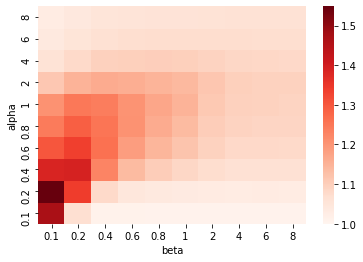

In [6]:
ax = sns.heatmap(
    np.mean(lu_pofs, axis=2),
    xticklabels=BETAS, yticklabels=ALPHAS,
    cmap='Reds', vmin=1
)
ax.invert_yaxis()
plt.ylabel('alpha')
plt.xlabel('beta');

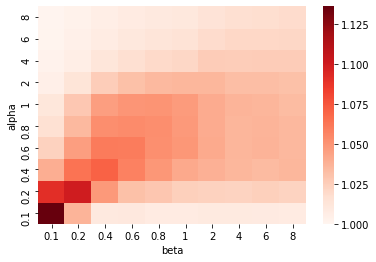

In [7]:
ax = sns.heatmap(
    np.mean(ln_pofs, axis=2),
    xticklabels=BETAS, yticklabels=ALPHAS,
    cmap='Reds', vmin=1
)
ax.invert_yaxis()
plt.ylabel('alpha')
plt.xlabel('beta');

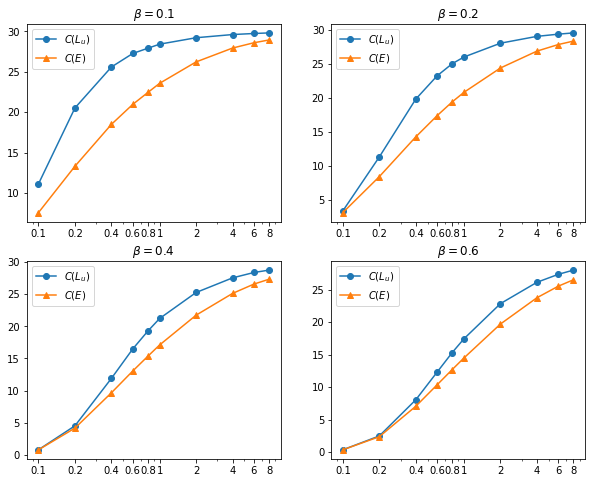

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

for b_id, b in enumerate(BETAS[: 4]):
    ax[b_id // 2][b_id % 2].plot(
        ALPHAS, np.mean(lu_costs[:, b_id, :], axis=1),
        label=r'$C(L_u)$', marker='o'
    )
    ax[b_id // 2][b_id % 2].plot(
        ALPHAS, np.mean(eff_costs[:, b_id, :], axis=1),
        label=r'$C(E)$', marker='^'
    )
    
    ax[b_id // 2][b_id % 2].set_xscale('log')
    ax[b_id // 2][b_id % 2].set_xticks(ALPHAS)
    ax[b_id // 2][b_id % 2].set_xticklabels(ALPHAS)
    
    ax[b_id // 2][b_id % 2].set_title(r'$\beta = $' + str(b))
    ax[b_id // 2][b_id % 2].legend()
    
plt.show()